# Setup

## Imports

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../src/')
from preprocessing import (
    filter_low_magnitude_genes,
    filter_high_mito_cells,
    filter_high_apoptosis_cells,
    filter_high_rrna_cells,
    normalize_by_library_size,
    log_transform,
    normalize_data_with_pearson,
    genes
)
from visualization import plot_gene_magnitude_distribution, plot_filtering_effect

## Data Loading

In [2]:
from data_loading import load_10x_data

DATA_PATH = '../data/'
raw_data = load_10x_data(DATA_PATH)

raw_data.shape

(5000, 33538)

# Gene Filtering

In [3]:
clean_data = filter_low_magnitude_genes(raw_data)

clean_data.shape

[Filter Magnitude] Dropped 19026 genes with max count < 2 (only 0s and 1s).


(5000, 14512)

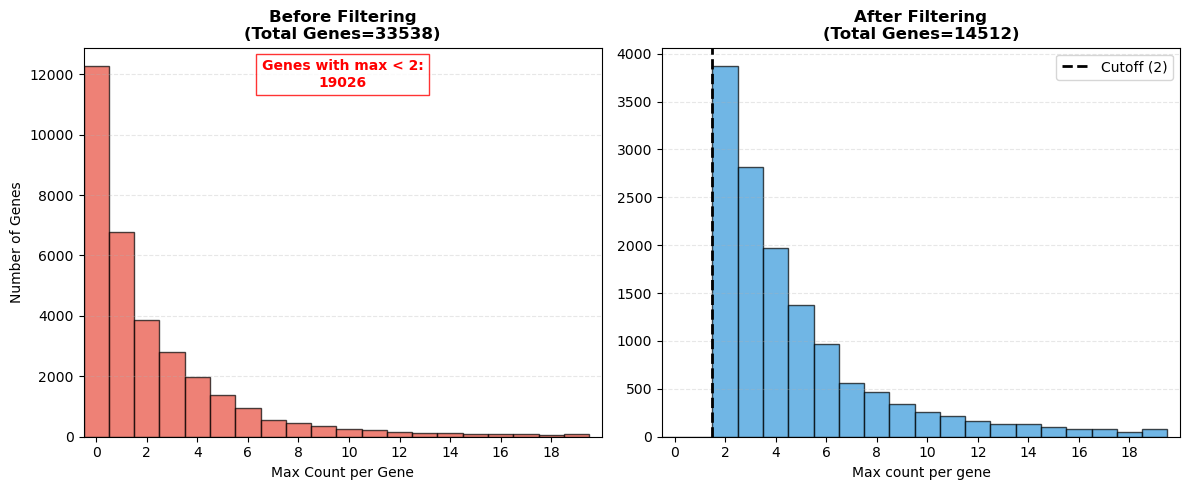

In [4]:
plot_gene_magnitude_distribution(raw_data, clean_data)

The "Before" plot reveals a massive number of genes whose maximum expression never exceeds 1 UMI count across the entire dataset. The "After" plot confirms that all remaining genes have a maximum count of at least 2.

# Quality Control (Cell Filtering)

## Mitochondrial

In [5]:
# Check if any starts with "MT-"
print("'MT-' genes:", clean_data.columns.str.startswith('MT-').sum())

# Check if any starts with "mt-" (Mouse)
print("'mt-' genes:", clean_data.columns.str.startswith('mt-').sum())

'MT-' genes: 13
'mt-' genes: 0


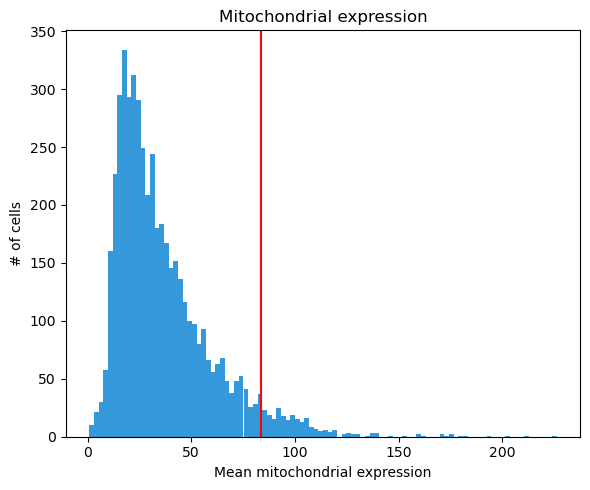

In [31]:
# get mitochondrial genes
mitochondrial_gene_list = np.array([g.startswith('MT-') for g in clean_data.columns])

# get expression
mito_exp = clean_data.loc[:,mitochondrial_gene_list].mean(axis=1)

# plotting
fig, ax = plt.subplots(1, figsize=(6,5))

ax.hist(mito_exp, bins=100, color='#3498db')
cutoff_value = float(np.percentile(mito_exp, 95))
ax.axvline(cutoff_value, color='red')
ax.set_xlabel('Mean mitochondrial expression')
ax.set_ylabel('# of cells')
ax.set_title('Mitochondrial expression')

fig.tight_layout()

In [7]:
data_mito_filtered = filter_high_mito_cells(clean_data)

data_mito_filtered.shape

[Filter Mito] Starting mitochondrial gene removal...
Cutoff: 0.0998 (Ratio)
Dropped 250 cells (Top 5% expression).


(4750, 14512)

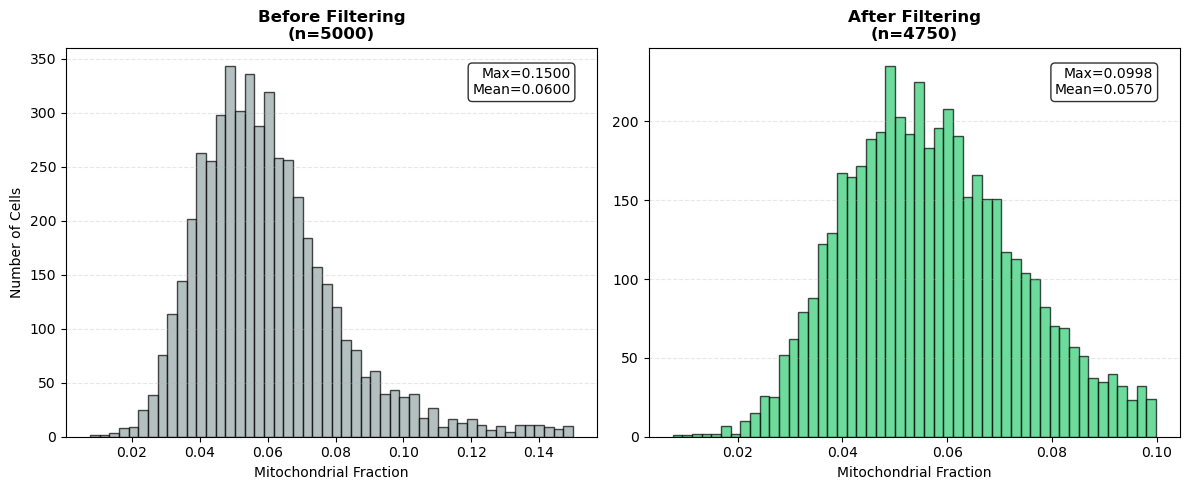

In [8]:
mito_genes = [col for col in clean_data.columns if col.startswith('MT-')]

plot_filtering_effect(
    data_before=clean_data,
    data_after=data_mito_filtered,
    gene_list=mito_genes,
    metric_name="Mitochondrial Fraction"
)

The distribution of mitochondrial reads shifts to the left after filtering. The "Before" plot shows a long tail extending up to ~15%, while the "After" plot is strictly truncated at 10%. This confirms that cells with ruptured membranes (high mitochondrial fraction) have been removed.

## Apoptosis

In [9]:
# Convert the list of apoptosis genes to a pandas Index for easy intersection
apoptosis_gene_index = pd.Index(genes.APOPTOSIS_GENES)

# This creates a new Index containing ONLY the common gene names.
overlapping_genes = raw_data.columns.intersection(apoptosis_gene_index)

# Use the list of overlapping genes to select only those columns from the data
apoptosis_data = raw_data[overlapping_genes]

print(f"Total genes in the dataset: {len(raw_data.columns)}")
print(f"Total genes in the APOPTOSIS_GENES list: {len(genes.APOPTOSIS_GENES)}")
print("-" * 40)
print(f"Number of apoptosis genes found in the data: {len(overlapping_genes)}")

Total genes in the dataset: 33538
Total genes in the APOPTOSIS_GENES list: 161
----------------------------------------
Number of apoptosis genes found in the data: 159


In [10]:
data_apoptosis_filtered = filter_high_apoptosis_cells(data_mito_filtered)

data_apoptosis_filtered.shape

[Filter Apoptosis] Starting apoptosis gene removal...
Cutoff: 0.0273 (Ratio)
Dropped 238 cells (Top 5% expression).


(4512, 14512)

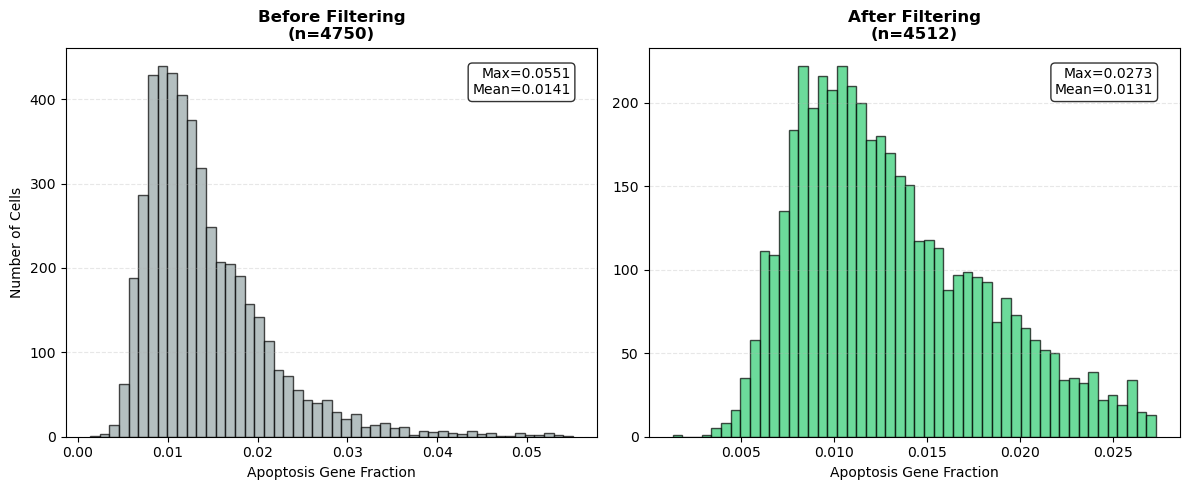

In [11]:
plot_filtering_effect(
    data_before=data_mito_filtered,
    data_after=data_apoptosis_filtered,
    gene_list=genes.APOPTOSIS_GENES,
    metric_name="Apoptosis Gene Fraction"
)

The apoptosis gene fraction was cut at ~2.7%. The "Before" plot reveals a skew of highly stressed cells (up to 5.5%), which are absent in the "After" plot. This step ensures we are analyzing healthy cells rather than those undergoing programmed cell death.

## rRNA

In [12]:
data_rrna_filtered = filter_high_rrna_cells(data_apoptosis_filtered)

data_rrna_filtered.shape

[Filter rRNA] Starting rRNA gene removal...
Cutoff: 0.4905 (Ratio)
Dropped 226 cells (Top 5% expression).


(4286, 14512)

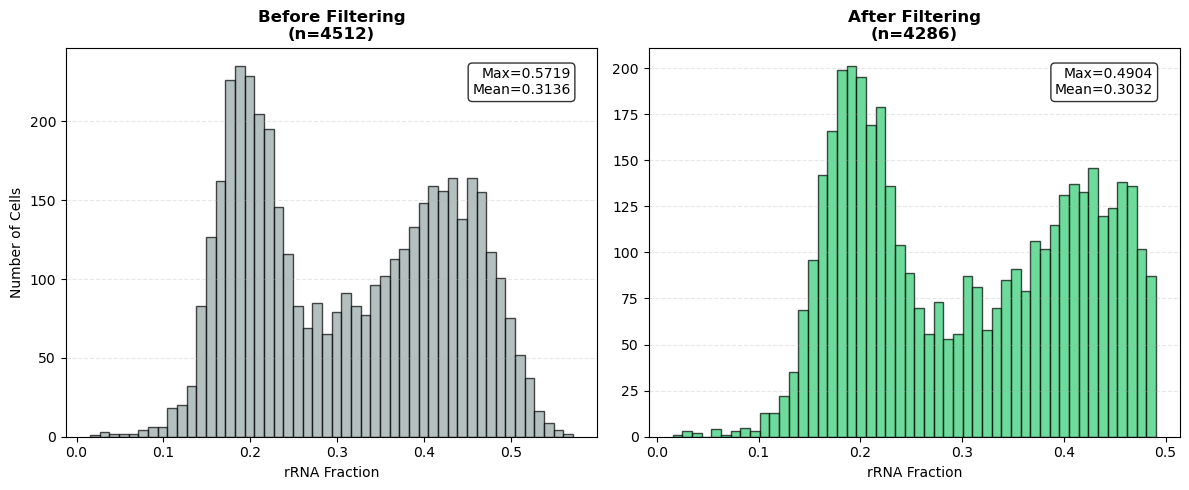

In [13]:
plot_filtering_effect(
    data_before=data_apoptosis_filtered,
    data_after=data_rrna_filtered,
    gene_list=genes.RRNA_GENES,
    metric_name="rRNA Fraction"
)

While the overall bimodal distribution of rRNA expression persists (biological or batch-related), the filter successfully removed the extreme technical outliers. The maximum rRNA fraction dropped from ~57% to ~49%, eliminating cells dominated by ribosomal genes.

# Normalization

## logCPM

### Normalize by library size

In [14]:
normalized_data = normalize_by_library_size(data_rrna_filtered)

normalized_data.shape

[Normalize] Normalizing library size (CPM) with rescale=1e+06...


(4286, 14512)

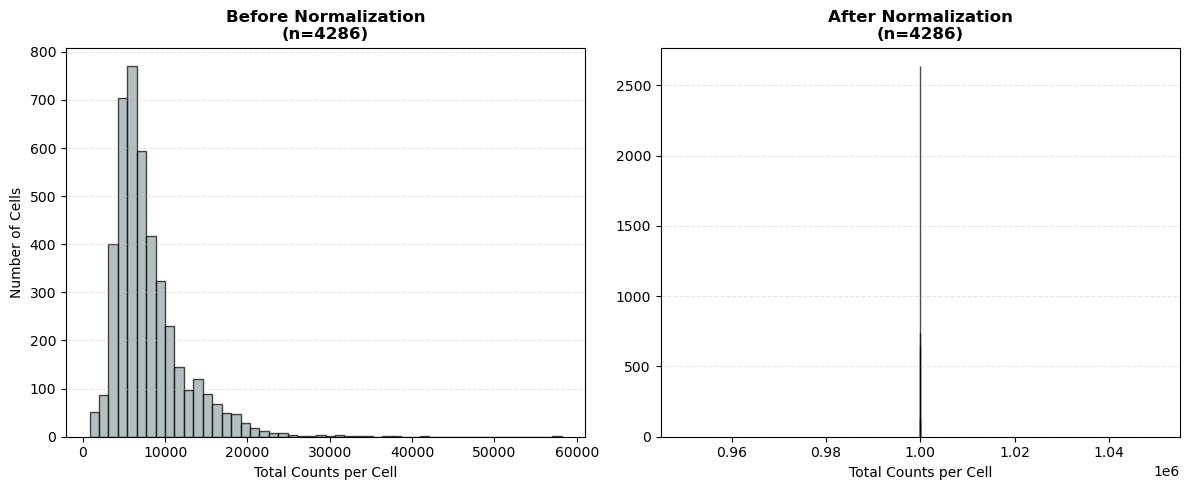

Mean Library Size Before: 7923
Mean Library Size After:  1000000


In [15]:
# Calculate library sizes (Total counts per cell)
# "Before" - The data coming out of the last filter (rRNA)
lib_size_before = data_rrna_filtered.sum(axis=1)

# "After" - The data coming out of normalization
lib_size_after = normalized_data.sum(axis=1)

# Plot Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Before (Distribution of Read Depths)
axes[0].hist(lib_size_before, bins=50, color='#95a5a6', edgecolor='black', alpha=0.7)
axes[0].set_title(f"Before Normalization\n(n={len(lib_size_before)})", fontweight='bold')
axes[0].set_xlabel("Total Counts per Cell")
axes[0].set_ylabel("Number of Cells")
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Plot After
axes[1].hist(lib_size_after, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].set_title(f"After Normalization\n(n={len(lib_size_after)})", fontweight='bold')
axes[1].set_xlabel("Total Counts per Cell")
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Print verification
print(f"Mean Library Size Before: {np.mean(lib_size_before):.0f}")
print(f"Mean Library Size After:  {np.mean(lib_size_after):.0f}")

The "Before" plot shows significant variation in sequencing depth across cells, with library sizes ranging from ~2,000 to ~50,000 reads. The "After" plot shows a single vertical line at $10^6$, confirming that normalization successfully scaled every cell to an identical total count (CPM).

### Log Transform

In [16]:
logged_data = log_transform(normalized_data)

logged_data.shape

[Transform] Applying log transform (log1+x)...


(4286, 14512)

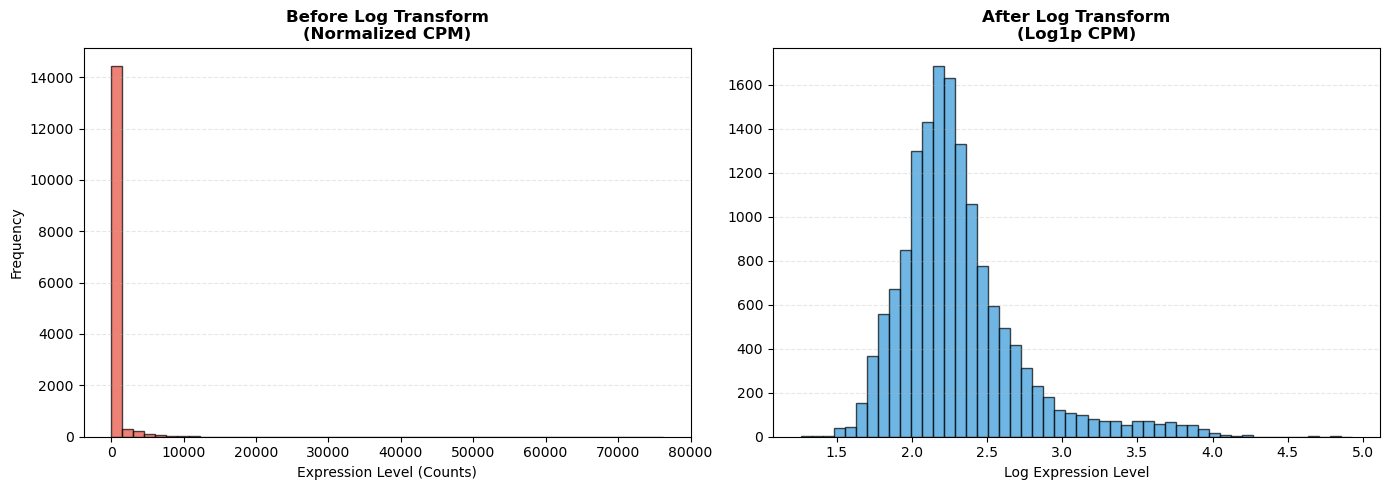

In [17]:
# --- 1. Data Preparation ---
# We flatten the matrix to treat all gene counts as a single pool of numbers.
# We sample 100,000 values to make plotting fast and avoid crashing.
np.random.seed(42) # For reproducibility
sample_size = 100000

# Flatten and sample "Before" (Normalized Data)
flat_norm = normalized_data.values.flatten()
if len(flat_norm) > sample_size:
    values_before = np.random.choice(flat_norm, sample_size, replace=False)
else:
    values_before = flat_norm

# Flatten and sample "After" (Logged Data)
flat_log = logged_data.values.flatten()
if len(flat_log) > sample_size:
    values_after = np.random.choice(flat_log, sample_size, replace=False)
else:
    values_after = flat_log

# Filter out pure zeros for a clearer view of the expression distribution
# Comment these out to see the zero-spike)
values_before = values_before[values_before > 0]
values_after = values_after[values_after > 0]

# --- 2. Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot "Before" (Linear Scale)
axes[0].hist(values_before, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0].set_title(f"Before Log Transform\n(Normalized CPM)", fontweight='bold')
axes[0].set_xlabel("Expression Level (Counts)")
axes[0].set_ylabel("Frequency")
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Plot "After" (Log Scale)
axes[1].hist(values_after, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_title(f"After Log Transform\n(Log1p CPM)", fontweight='bold')
axes[1].set_xlabel("Log Expression Level")
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

The left distribution is extremely skewed (power law). Most values are bunched near zero, while a few high-expression genes stretch the x-axis out to huge numbers (e.g., > 10,000), making the data hard to visualize or model.
The log transformation pulls the extreme outliers in, creating a distribution that looks much more "bell-shaped" (Gaussian). This stabilizes the variance and makes the data suitable for downstream statistical analysis like PCA and differential expression.

## Pearson residuals

In [18]:
pearsons_data = normalize_data_with_pearson(data_rrna_filtered)

pearsons_data.shape

[Residuals] Computing Pearson residuals for 4286 cells using Scanpy...
Selecting top 3000 variable genes...
Calculating residuals...


(4286, 3000)

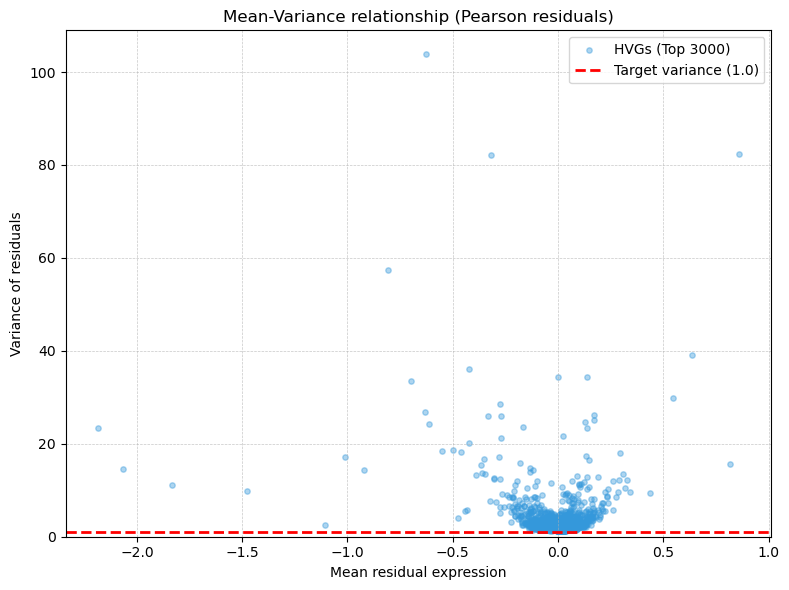

In [30]:
# Calculate Mean and Variance
gene_means = pearsons_data.mean(axis=0)
gene_vars = pearsons_data.var(axis=0)

# Plotting
plt.figure(figsize=(8, 6))

# Scatter plot of genes
plt.scatter(
    gene_means, 
    gene_vars, 
    alpha=0.4,    # Make points semi-transparent to see density
    s=15,         # Small marker size
    color='#3498db',
    label='HVGs (Top 3000)'
)

# Add a reference line at Variance - 1.0
# This is the theoretical target for Pearson residuals
plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label="Target variance (1.0)")

# 4. Formatting/Styling
plt.title("Mean-Variance relationship (Pearson residuals)")
plt.xlabel("Mean residual expression")
plt.ylabel("Variance of residuals")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ensure y-axis starts at 0 for clarity
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# High Variable Genes

/var/folders/yg/gln7v6491d5dgt0g56xdtn9w0000gn/T/ipykernel_5624/1046078772.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  gene_variance = pd.Series(np.nanvar(data_array, axis=0), index=data.columns).fillna(0)
/var/folders/yg/gln7v6491d5dgt0g56xdtn9w0000gn/T/ipykernel_5624/1046078772.py:17: RuntimeWarning: Mean of empty slice
  gene_mean = pd.Series(np.nanmean(data_array, axis=0), index=data.columns).fillna(0)


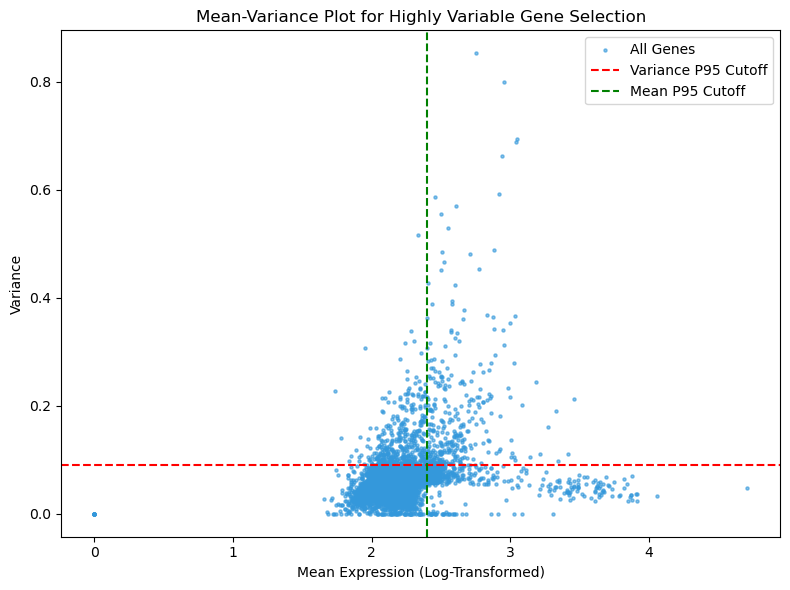


Default mean cutoff (P95): 2.4027
Default variance cutoff (P95): 0.0901


In [35]:
def calculate_hvg_metrics(data: pd.DataFrame):
    """Calculates non-zero mean and variance for each gene."""
    
    # Create a mask for non-zero values
    non_zero_mask = data > 0

    # Calculate variance and mean only where the gene is expressed
    # This replaces all original zeros with NaN
    non_zero_data = data.mask(~non_zero_mask)

    # Convert the masked DataFrame to a standard NumPy array to avoid SparseTypeError
    data_array = non_zero_data.values 

    # Use numpy.nanvar and numpy.nanmean to calculate statistics, which handles NaNs
    # Wrap results in a pandas Series to keep the gene names (columns) and fill NaNs with 0
    gene_variance = pd.Series(np.nanvar(data_array, axis=0), index=data.columns).fillna(0)
    gene_mean = pd.Series(np.nanmean(data_array, axis=0), index=data.columns).fillna(0)
    # --- END FIX ---

    # Combine into a single DataFrame for easy plotting and percentile calculation
    hvg_df = pd.DataFrame({
        'mean': gene_mean,
        'variance': gene_variance
    })
    return hvg_df

hvg_metrics = calculate_hvg_metrics(logged_data)


P_MEAN = 95
P_VAR = 95
mean_cutoff = float(np.percentile(hvg_metrics['mean'], P_MEAN))
var_cutoff = float(np.percentile(hvg_metrics['variance'], P_VAR))


# --- Plot the Mean-Variance relationship ---
fig, ax = plt.subplots(1, figsize=(8, 6))

# Scatter plot all genes
ax.scatter(hvg_metrics['mean'], hvg_metrics['variance'], s=5, alpha=0.6, label='All Genes', color='#3498db')

# Highlight the cutoffs
ax.axhline(var_cutoff, color='red', linestyle='--', label=f'Variance P{P_VAR} Cutoff')
ax.axvline(mean_cutoff, color='green', linestyle='--', label=f'Mean P{P_MEAN} Cutoff')

ax.set_xlabel('Mean Expression (Log-Transformed)')
ax.set_ylabel('Variance')
ax.set_title('Mean-Variance Plot for Highly Variable Gene Selection')
ax.legend()
fig.tight_layout()
plt.show()

print(f"\nDefault mean cutoff (P{P_MEAN}): {mean_cutoff:.4f}")
print(f"Default variance cutoff (P{P_VAR}): {var_cutoff:.4f}")
